# Iris Dataset Classification Using Logistic Regression
- This is a multi-class logistic regression problem.
- While there are several ways to handle a multi-class classification (OvR, OvO, and multinomial logistic regression) we use multinomial logistic regression.
- The loss function is the log-loss function, implemented in `sklearn.metrics.log_loss`.
- The obvious candidates for feature engineering (such as sepal and petal area) did improve the loss, but could not improve performance in terms of accuracy or F1 score. Thus, the attempts at feature engineering have not been included here.
- The performance on the test set was measured using the confusion matrix, and metrics such as precision, recall, and F1 score (macro/weighted), implemented in `sklearn.metrics.classification_report`

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris-flower-dataset/IRIS.csv


In [2]:
iris_dataset = pd.read_csv('/kaggle/input/iris-flower-dataset/IRIS.csv')

In [3]:
iris_dataset.info() # no null values. No need to preprocess nulls.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Looking at the Data

### Performing the Train/Validation/Test split

In [4]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(iris_dataset.drop('species',axis=1),
                                       iris_dataset['species'],
                                       test_size = 0.2,
                                       random_state = 42,
                                       stratify = iris_dataset['species'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,
                                                 random_state=42, stratify=y)
print(f"The shape of the training data is: X_train={X_train.shape}, y_train = {y_train.shape}")
print(f"The shape of the validation data is: X_val={X_val.shape}, y_val = {y_val.shape}")
print(f"The shape of the testing data is: X_test = {X_test.shape}, y_test = {y_test.shape}")

The shape of the training data is: X_train=(90, 4), y_train = (90,)
The shape of the validation data is: X_val=(30, 4), y_val = (30,)
The shape of the testing data is: X_test = (30, 4), y_test = (30,)


In [5]:
# these will be used later, when we try to solve the problem using some additional features
X_train2 = X_train.copy()
X_val2 = X_val.copy()
y_train2 = y_train.copy()
y_val2 = y_val.copy()

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 124 to 88
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  90 non-null     float64
 1   sepal_width   90 non-null     float64
 2   petal_length  90 non-null     float64
 3   petal_width   90 non-null     float64
dtypes: float64(4)
memory usage: 3.5 KB


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [8]:
cols = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = cols

cols = X_val.columns
X_val = pd.DataFrame(scaler.transform(X_val))
X_val.columns = cols

cols = X_test.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns = cols


In [9]:
X_train.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01
mean,7.524845e-16,-7.767321e-16,4.656769e-17,1.662251e-16
std,1.005602e+00,1.005602e+00,1.005602e+00,1.005602e+00
min,-1.784077e+00,-2.461613e+00,-1.506295e+00,-1.445697e+00
25%,-8.552731e-01,-6.907172e-01,-1.222326e+00,-1.182044e+00
50%,-1.006204e-01,-1.899812e-02,2.827063e-01,1.362206e-01
75%,6.540324e-01,4.695249e-01,7.654527e-01,7.953528e-01
max,2.395539e+00,2.179355e+00,1.787739e+00,1.718138e+00


In [10]:
y_train.value_counts()

species
Iris-virginica     30
Iris-setosa        30
Iris-versicolor    30
Name: count, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

In [12]:
show_data=X_train.copy()
idx = show_data.index
show_data = show_data.reset_index(drop=True)
show_data['species'] = y_train.reset_index(drop=True)
show_data.index = idx

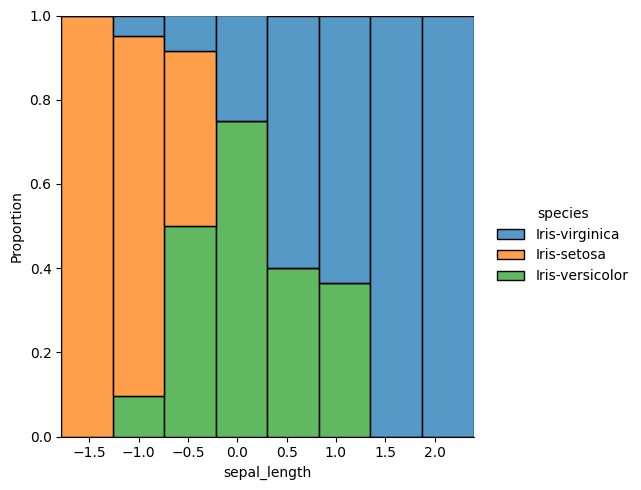

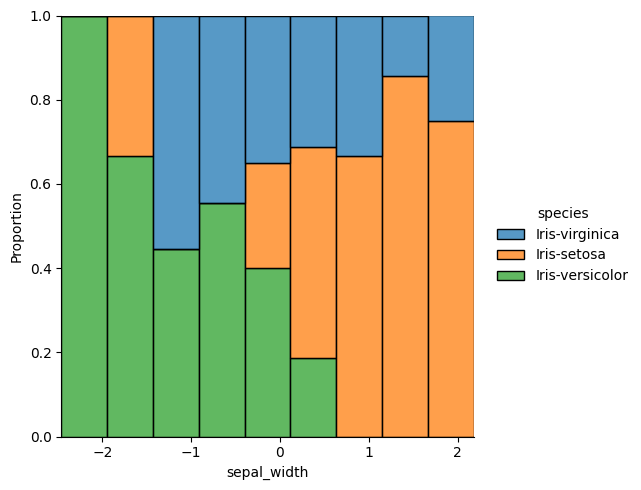

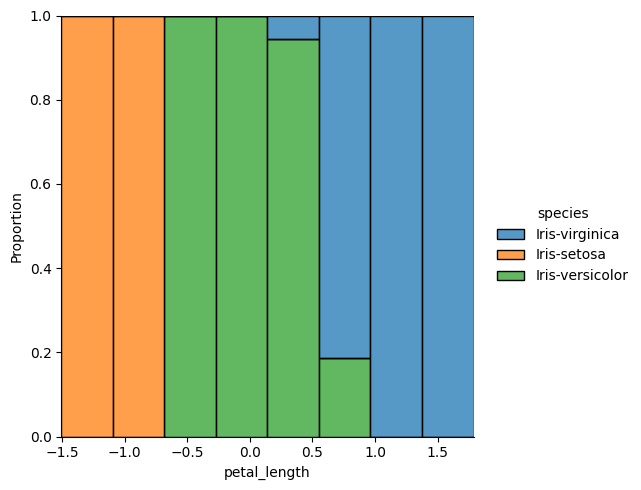

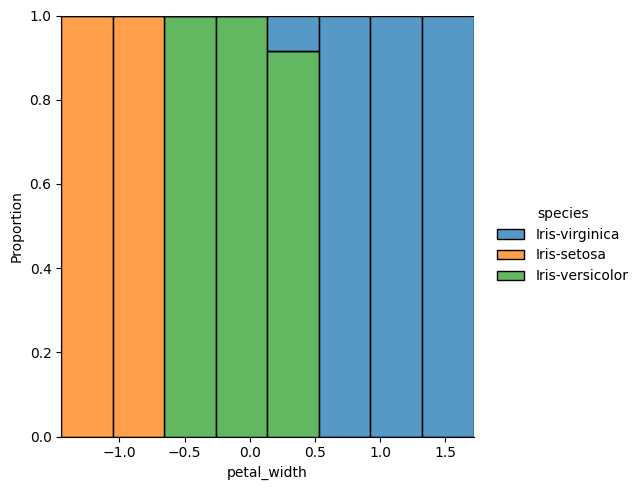

In [13]:
for x_col in list(X_train.columns):
    sns.displot(data=show_data, x=x_col, hue='species', multiple='fill', stat='proportion')
    plt.show()

From the above plots we can make some simple observations:
- iris_setosa has low sepal length, high sepal_width, small petal_length, and small petal_width
- iris_versicolor is moderate on all of these values except sepal_width, which is low.
- iris_virginica has high sepal length, low to medium-high sepal width,  high petal length and high petal width.

Some possible additional features that we can use are:

- petal area
- sepal area
- the ratio of petal area to sepal area
- the aspect ratio of the petal and sepal

Attempting to add these features did tend to decrease the loss marginally, implying the classifier was making better predictions, but it did not have any impact on the resulting F1 score (or accuracy). Thus, the analysis has not been included in the final notebook presented here.

## Performing Multi-Class Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed

def parallel_search(param, X_train, y_train, X_val, y_val):
    '''
    This is a helper function that takes in the parameter choice for Logistic Regression 
    and finds the training and validation loss after training the Classifier with the specified
    parameters. We will parallelize this using `joblib`.
    '''
    logistic_regression_classifier = LogisticRegression().set_params(**param)                                                                               
    logistic_regression_classifier.fit(X_train, y_train)
    y_pred_train_proba = logistic_regression_classifier.predict_proba(X_train)
    y_pred_val_proba = logistic_regression_classifier.predict_proba(X_val)
    train_loss = log_loss(y_train, y_pred_train_proba, normalize=True)
    val_loss = log_loss(y_val, y_pred_val_proba, normalize=True)
    return [param, train_loss, val_loss]


def parameter_search(param_dict, X_train, y_train, X_val, y_val):
    '''
    This function performs parameter searching given a dict of possible parameters `param_dict`.
    This is done in parallel using joblib.
    '''
    results = []
    param_grid = ParameterGrid(param_dict)
    results = np.array(Parallel(n_jobs=-1)(delayed(parallel_search)(param, X_train, y_train, X_val, y_val) for param in param_grid))
    res = pd.DataFrame({"parameters": results[:,0],
                       "training_loss": results[:,1],
                       "validation_loss":results[:,2]})
    return res


In [15]:
param_dict = {'penalty': ["l2"], # only choice that works for multiple solvers.
             'dual': [False],
             'tol': [1e-4,1e-3,1e-2,1e-1,1,10,100],
             'C': [0.1,0.3,1.0,3.0],
             'class_weight': ['balanced', None],
             'random_state':[42],
             'solver':['lbfgs', 'newton-cg','sag', 'saga'],
             'max_iter':[3_000, 10_000],
             'multi_class':['multinomial'],
             'n_jobs': [-1]}

In [16]:
loss_df = parameter_search(param_dict,X_train, y_train, X_val, y_val)

In [17]:
loss_df.head()

,parameters,training_loss,validation_loss
0,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",0.370451,0.394186
1,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",0.370446,0.39418
2,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",0.370464,0.394152
3,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",0.370339,0.394455
4,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",0.372116,0.397128


In [18]:
loss_df[loss_df['validation_loss'] == np.min(loss_df['validation_loss'])]

,parameters,training_loss,validation_loss
352,"{'C': 3.0, 'class_weight': 'balanced', 'dual':...",0.08563,0.169711
380,"{'C': 3.0, 'class_weight': 'balanced', 'dual':...",0.08563,0.169711
408,"{'C': 3.0, 'class_weight': None, 'dual': False...",0.08563,0.169711
436,"{'C': 3.0, 'class_weight': None, 'dual': False...",0.08563,0.169711


In [19]:
optimal_sol = loss_df[loss_df['validation_loss'] == np.min(loss_df['validation_loss'])].iloc[0]

In [20]:
classifier = LogisticRegression().set_params(**optimal_sol['parameters'])

In [21]:
classifier.fit(X_train, y_train)

LogisticRegression(C=3.0, class_weight='balanced', max_iter=3000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='sag', tol=0.01)

In [22]:
print("The loss on the training dataset is:", optimal_sol['training_loss'].round(3))
print("The loss on the validation dataset is:", optimal_sol['validation_loss'].round(3))
y_pred_test_proba = classifier.predict_proba(X_test)
print("The loss on the test dataset is:", log_loss(y_test,y_pred_test_proba).round(3))

The loss on the training dataset is: 0.086
The loss on the validation dataset is: 0.17
The loss on the test dataset is: 0.151


In [23]:
print("The train accuracy is:", classifier.score(X_train, y_train).round(3))
print("The validation accuracy is:", classifier.score(X_val, y_val).round(3))
print("The test accuracy is:", classifier.score(X_test, y_test).round(3))

The train accuracy is: 0.978
The validation accuracy is: 0.933
The test accuracy is: 0.933


## Precision, Recall, F1 Score on Test Set

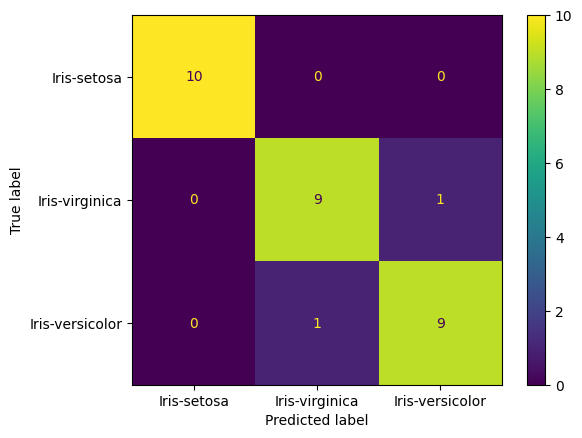

In [24]:
y_pred_test = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=y_test.unique()).plot(); # confusion matrix

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, 
                     y_pred_test,
                     labels = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'],
                     target_names = ['Iris-versicolor', 'Iris-setosa', 'Iris-virginica']))

                 precision    recall  f1-score   support

Iris-versicolor       0.90      0.90      0.90        10
    Iris-setosa       1.00      1.00      1.00        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30

